In [10]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.pynetlogo_utils import initialize_netlogo

base_model = "./M4Model_Dresslar_base.nlogo"  # (copied into this directory!)
modified_model = "./M4Model_Dresslar_modified.nlogo"

Procedure
Step 1: Intra-model Stochasticity
Examining the model code, identify and describe the stochastic elements in the model.

Step 2: Sensitivity Analysis
Perform a sensitivity analysis of the Altruism model with the Cost, Benefit, Harshness and Disease parameters, and Altruistic and Selfish population numbers as the currencies.  First, identify the number of runs you will use for the analysis. Then, start by exploring Cost and Benefit parameters with Disease and Cost set to 0, then add positive values of Disease and Cost.

Evaluation Method
This total assignment is worth 50 pts: 10 pts for Step 1 and 40 pts for Step 2.

Submission Expectations
Step 1 should be submitted as a PDF file with the title M4Step1_[last name].pdf, and could even be a highlighted and notated rendition of the model code. A text analysis is also fine.

For Step 2, if you use a notebook post an HTML version of the notebook with the title M4Analysis_[last name].html, and if you use another analysis tool please submit a analysis report with graphs as a PDF file with the title M2Analysis_[last name].pdf, Be sure your notebook and report is contains detailed commentary about your analysis steps, decisions and observations.

In [11]:
# defaults

altruistic_probability = 0.26
selfish_probability = 0.26
cost_of_altruism = 0.13
benefit_from_altruism = 0.48
disease = 0.0
harshness = 0.0


# Introduction

The NetLogo model, "Altruism" (Wilensky 1998), ships as a Agent Based Model that can be evaluated in the NetLogo computational framework. 

Agents in the context of agent based models are model elements that might have properties and/or state information. We might loosely define properties as immutable data relating to the agents, and state as mutable date relating to the agents. 

Agents can be operated on individually or in batches--the latter being inferrable by the former--using computational rules. NetLogo operates with different agent "classes" and can be operated with many different evaluation settings, but for our discussion we will assume that the salient features of the agents in the Altruism model are that they are called "patches" in the NetLogo implementation framework, and that each individual agent is assigned a "location" in a two-dimensional network which it shares with all the other agents. Out of the box, the graph of the network is a 41 x 41 grid, filled completely with 1,681 patch agents, with operations wrapping both horizontally and vertically across the edges of the grid. Patches, once assigned to a location in the network with x and y coordinates, do not move: that is to say, the containers of state do not change in order of the grid. All agents in the NetLogo Altruism model have access to all properties and state values of all other agents.

The agents of Altruism operate within a domain with (in the base model) six assignable parameters:

- `altruistic-probability`
- `selfish-probability`
- `cost-of-altruism`
- `benefit-from-altruism`
- `disease`
- `harshness`

Each of these parameters is defined as a variable containing a floating point value. We call these domain parameters since they apply to all elements within the model (and are accessible to all elements within the model), and they are set independently of the modelʻs operation. The parameters can be set by the end-user of the model through user interface controls; these controls restrict the parameters to ranges between 0 and .5 < limit 1, inclusive. It might be noted that these restrictions could be overridden arbitrarily in code or even by an ambitious end-user; they might be seen as range *recommendations*. Importantly, it might also be noted that the values can be reset at anytime of the modelʻs operation; this is a much more complex operational envelope that we will ignore for the purposes of this exercise. We will instead limit our investigation to model executions with unchanging domain parameters.

In the base model, Altruism endows each agent with the same state variables. In other words, while the agents of Altruism can be heterogenous with respect to state values, they are monotonic in terms of state variable (by virtue of being defined once globally) definitions. Outside of graph position (and some trivial technical settings; see below) the Altruism are monotonic with respect to properties; by virtue of being "patches" in NetLogo, they all behave identically under identical conditions (with the exception of operations dependent on their network properties).

Before we continue, we must mention the `pcolor` property of NetLogo agents. This is another built-in property that controls the visual color display of the agents, including patches---this would seem to be a trivial technical setting in other contexts. However, since NetLogo lacks enumerated typing, the `pcolor` property is often appropriated by developers to assign meaningful states, frequently ones that class groups of agents in some way or ways. Thus, while most technical settings would never be used to alter data directly, `pcolor` often becomes a fundamental aspect of the modelʻs operation.[^1] is entirely the case with Altruism. So, we will treat `pcolor` as a an agent property that is defined by the implementation but *re-defined* by the developer as an agent state variable. [^2]

The following list includes each agent state variable and some interesting facts about each:

| name | description | initial assignment | S0 variable type WRT domain | S0 variable type WRT agents | operational variable type WRT domain | operational variable type WRT agents |
|-----|-----|-----|-----|-----|-----|-----|
| pcolor | assigns an enumerated type to an agent to control some processing flows | random-float function | stochastically dependent on domain parameters | independent | stochastically dependent on domain parameters | stochastically dependent on other agent states|
| benefit-out | an implementation detail maintained in lockstep with pcolor; effectively a compound variable | random-float function | stochastically dependent on domain parameters | independent | stochastically dependent on domain parameters | stochastically dependent on other agent states|
| altruism-benefit | used by processing rules; sigificant component of fitness setting | implicitly 0 | independent | independent | directly and or stochastically dependent on domain parameters | stochastically dependent on other agent states |
| fitness | used by processing rules; directly controls inter-step behavior of self and network neighbors | implicitly 0 | independent | independent | directly and or stochastically dependent on domain parameters | stochastically dependent on other agent states |
| self-weight | used by processing rules, temporal, effectively reinitialized each tick | initialized functionally | directly dependent | directly dependent | stochastically dependent on domain parameters | stochastically dependent on other agent states|
| self-fitness | used by processing rules, temporal, reinitialized each tick | implicitly 0 | independent | independent | stochastically dependent on domain parameters | stochastically dependent on other agent states|
| alt-weight | used by processing rules, temporal, effectively reinitialized each tick | initialized functionally | directly dependent | directly dependent | stochastically dependent on domain parameters | stochastically dependent on other agent states|
| alt-fitness | used by processing rules, temporal, reinitialized each tick | implicitly 0 | independent | independent | stochastically dependent on domain parameters | stochastically dependent on other agent states|
| harsh-weight | used by processing rules, temporal, effectively reinitialized each tick| implicitly 0 | initialized functionally | directly dependent | directly dependent| stochastically dependent on other agent states|
| harsh-fitness | used by processing rules, temporal, reinitialized each tick | implicitly 0 | independent | independent | stochastically dependent on domain parameters | stochastically dependent on other agent states|

--

The following is not an agent state variable, but behaves like one:

| name | description | initial assignment | initialization variable type WRT domain | initialization variable type WRT agents | operational variable type WRT domain | operational variable type WRT agents |
|-----|-----|-----|-----|-----|-----|-----|
| fitness-sum | aggregates fitness scores and disease across all states | dependent on agents and domain params | not initialized until run | not initialized until run | dependent on domain parameters | stochastically dependent on other agent states |

--

The following is not an agent state variable, but might be confused as one:

| name | description | initial assignment | initialization variable type WRT domain | initialization variable type WRT agents | operational variable type WRT domain | operational variable type WRT agents |
|-----|-----|-----|-----|-----|-----|-----|
| breed-chance | influences agent operations | random-float function | independent | independent | independent | independent

That this variable is called once per step and used for the assignment of the pcolor/benefit-out compound variable makes it critical to the design of the model. It is an interesting implementation choice to leave it effectively as a population-wide variable.

--

All initial state assignments are applied one at a time, in a sequence executed by the randomizing `ask patches` command. We will discuss the stochastic nature of the command below; however, in the context of initial state assignment, the order in which assignment occurs for individual agents does not appear to make a difference to execution outcomes, and it seems likely that there is generalizable assertion about models along those lines.ʻ

### Implicit Agent Population-Level Variables

In many NetLogo models, much of the "point" of the model is the temporaly-situated proportionate existance and state of the agents. 

This is certainly true for Altruism, whose primary point of model "interest" is the survival of the classes (`pcolor`s) of agents. A secondary point would be those survival rates taken at specific model time points. (e.g., do the altruists die out quickly? slowly?) A tertiary interest point would be the rates of change as the model executes, and whether equilibria or other complex phenomena are exhibited.

The counts of agents by `pcolor` by time step are thus important model variables, but they are handled implicitly. The user interface implemented for Altruism displays both current and historical counts of patches by `pcolor`, but these are generated programmatically rather than stored as declared state variables. Netlogo handles model-wide groupings of agents through the Agentset class, which contains the count function as well as any other implicit variables for the populations.

### Time

Time is mysterious. The NetLogo ticks model stands in as a compehensible approximation of discrete causally-ordered steps, with causal order in the direction congruous with the arrow of time. Individual agent updates further divide these ticks into additional causally-ordered steps.

## Intra-model stochasicity and inter-agent setting (Step 1)

Place variable network diagram here

### About `ask-patches`

Possibly the most stochastic element model of all is a hidden one: the `ask patches` command. Used for all of specific agent updates in the model, `ask patches` by default selects all the patch agents, one at a time, in a random order. This randomness, for some models, would not make a difference at all---the order of operation on inidvidual patches that are all generally the same and operating indepently would be the same in any other. However, in Altruism, patches not only interact, but their physical proximity to their network neighbors is critical. Therefore, we might expect that there could be some difference in processing behavior even for different distributions of randomness (`ask patches`, apparently, uses a normal random distribution.) 

To illustrate the impact of this effect, a modified version of the model has been developed at M4Model_Dresslar_modified.nlogo. The modified version contains sort-ordered major processing commands for benefit and fitness checking, plus the lottery. This model can be compared with the model at M4Model_Dresslar_base.nlogo. Both have expanded telemetry functions to measure the application of altruism throughout the model.

*Note:* each model has also been modified to halt on the extinction of pink or green patches.

Running base model 1 of 2
Running modified model 1 of 2
Running base model 2 of 2
Running modified model 2 of 2


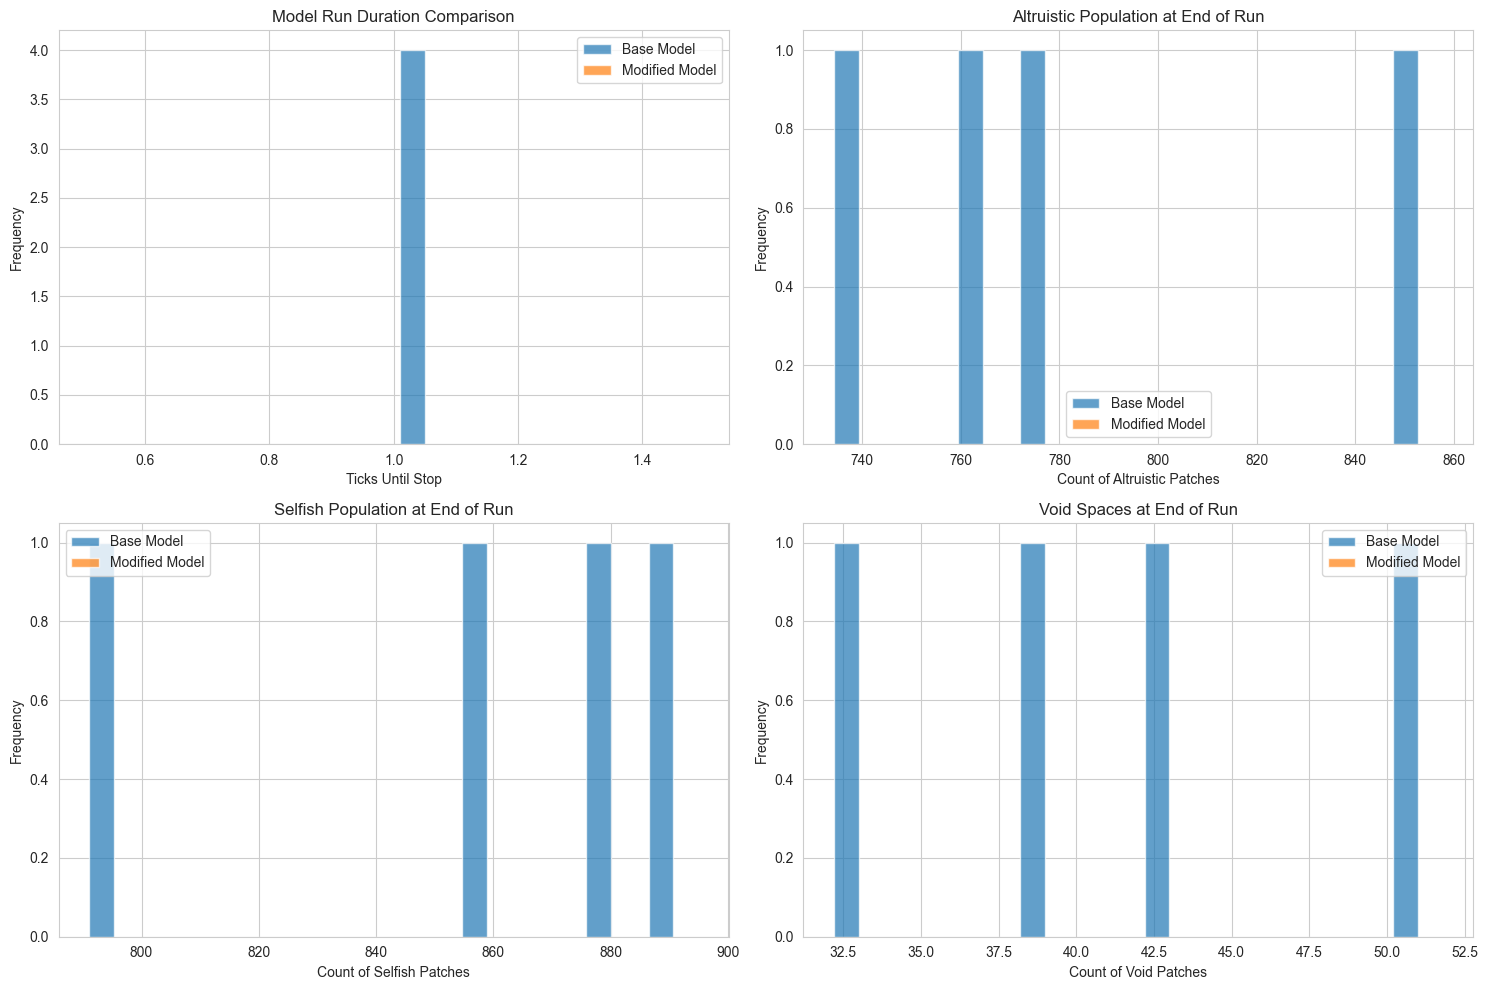

Summary Statistics:
------------------
Base Model Avg Ticks: 1.00 ± 0.00
Modified Model Avg Ticks: nan ± nan
Base Model Final Altruists: 784.50 ± 46.27
Modified Model Final Altruists: nan ± nan
Base Model Final Selfish: 855.25 ± 40.00
Modified Model Final Selfish: nan ± nan


/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# run each model 100 times at a point that will always collapse


base_model_ticks_to_stop = []
base_model_pinks_count = []
base_model_greens_count = []
base_model_voids_count = []
modified_model_ticks_to_stop = []
modified_model_pinks_count = []
modified_model_greens_count = []
modified_model_voids_count = []

max_ticks = 1000

runs_each = 2

# we can try running simultaneously

for i in range(runs_each):
    print(f"Running base model {i+1} of {runs_each}")
    netlogo = initialize_netlogo(base_model)
    netlogo.command(f"set altruistic-probability {altruistic_probability}")
    netlogo.command(f"set selfish-probability {selfish_probability}")
    netlogo.command(f"set cost-of-altruism {cost_of_altruism}")
    netlogo.command(f"set benefit-from-altruism {benefit_from_altruism}")
    netlogo.command(f"set disease {disease}")
    netlogo.command(f"set harshness {harshness}")
    netlogo.command("setup")
    netlogo.command(f"set max-ticks {max_ticks}")   # must be AFTER setup
    netlogo.command("go")
    base_model_ticks_to_stop.append(netlogo.report("ticks"))
    base_model_pinks_count.append(netlogo.report("count patches with [pcolor = pink]"))
    base_model_greens_count.append(netlogo.report("count patches with [pcolor = green]"))
    base_model_voids_count.append(netlogo.report("count patches with [pcolor = black]"))
    netlogo.kill_workspace()
    
    
    print(f"Running modified model {i+1} of {runs_each}") # ;; eh, why not.
    netlogo = initialize_netlogo(modified_model)
    netlogo.command(f"set altruistic-probability {altruistic_probability}")
    netlogo.command(f"set selfish-probability {selfish_probability}")
    netlogo.command(f"set cost-of-altruism {cost_of_altruism}")
    netlogo.command(f"set benefit-from-altruism {benefit_from_altruism}")
    netlogo.command(f"set disease {disease}")
    netlogo.command(f"set harshness {harshness}")
    netlogo.command("setup")
    netlogo.command(f"set max-ticks {max_ticks}")   # must be AFTER setup
    netlogo.command("go")
    modified_model_ticks_to_stop.append(netlogo.report("ticks"))
    modified_model_pinks_count.append(netlogo.report("count patches with [pcolor = pink]"))
    modified_model_greens_count.append(netlogo.report("count patches with [pcolor = green]"))
    modified_model_voids_count.append(netlogo.report("count patches with [pcolor = black]"))
    netlogo.kill_workspace()



# Set a consistent style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Histogram of tick numbers for each model
plt.subplot(2, 2, 1)
plt.hist([base_model_ticks_to_stop, modified_model_ticks_to_stop], 
         bins=10, alpha=0.7, label=['Base Model', 'Modified Model'])
plt.xlabel('Ticks Until Stop')
plt.ylabel('Frequency')
plt.title('Model Run Duration Comparison')
plt.legend()

# 2. Histogram of pink patch counts (altruists)
plt.subplot(2, 2, 2)
plt.hist([base_model_pinks_count, modified_model_pinks_count], 
         bins=10, alpha=0.7, label=['Base Model', 'Modified Model'])
plt.xlabel('Count of Altruistic Patches')
plt.ylabel('Frequency')
plt.title('Altruistic Population at End of Run')
plt.legend()

# 3. Histogram of green patch counts (selfish)
plt.subplot(2, 2, 3)
plt.hist([base_model_greens_count, modified_model_greens_count], 
         bins=10, alpha=0.7, label=['Base Model', 'Modified Model'])
plt.xlabel('Count of Selfish Patches')
plt.ylabel('Frequency')
plt.title('Selfish Population at End of Run')
plt.legend()

# 4. Histogram of black patch counts (voids)
plt.subplot(2, 2, 4)
plt.hist([base_model_voids_count, modified_model_voids_count], 
         bins=10, alpha=0.7, label=['Base Model', 'Modified Model'])
plt.xlabel('Count of Void Patches')
plt.ylabel('Frequency')
plt.title('Void Spaces at End of Run')
plt.legend()

plt.tight_layout()
plt.show()

# Add a summary statistics table
print("Summary Statistics:")
print("------------------")
print(f"Base Model Avg Ticks: {np.mean(base_model_ticks_to_stop):.2f} ± {np.std(base_model_ticks_to_stop):.2f}")
print(f"Modified Model Avg Ticks: {np.mean(modified_model_ticks_to_stop):.2f} ± {np.std(modified_model_ticks_to_stop):.2f}")
print(f"Base Model Final Altruists: {np.mean(base_model_pinks_count):.2f} ± {np.std(base_model_pinks_count):.2f}")
print(f"Modified Model Final Altruists: {np.mean(modified_model_pinks_count):.2f} ± {np.std(modified_model_pinks_count):.2f}")
print(f"Base Model Final Selfish: {np.mean(base_model_greens_count):.2f} ± {np.std(base_model_greens_count):.2f}")
print(f"Modified Model Final Selfish: {np.mean(modified_model_greens_count):.2f} ± {np.std(modified_model_greens_count):.2f}")




## Sensitivity analysis (Step 2)

### Notes

[] It might be noted that there is something fundamentally interesting about this phenomenon with respect to the intentional implementation of models by humans. `pcolor` is very frequently used.

[] It could easily be thought that the `pcolor` variable is specifically sub-classing the agents, but this is not fundamentally true, since the state variables are all the same regardless of `pcolor`, and the rules executed are also the same, regardless of `pcolor`. In this way, the patch agents are monotonically "agenty."